In [1]:
import neuromancer
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from scipy.integrate import solve_ivp

print("success")

success


# Load and create data

In [2]:
def budworm_ode(t,x,r,k):
    return r*x*(1-x/k) - x**2 / (1+x**2)


def simulate_steady_state(k_vals, x0):
    t_span = [0,100]
    t_eval = [t_span[-1]]
    r=0.56
    x_vals = []
    x_curr = x0
    for k in tqdm(k_vals):
        sol = solve_ivp(budworm_ode, t_span=t_span, y0=[x_curr],args = (r,k,), t_eval=t_eval)
        x_curr = sol.y[0,-1]
        x_vals.append(x_curr)
    return np.array(x_vals)

In [3]:
from sympy import symbols, Eq, solve, simplify

r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
k1, k2 = solve(Eq(D_fixed, 0), k)
print(k1,k2)

k_vals = np.linspace(float(k1)-1, float(k2)+1, 201) 

6.44569072482332 9.93441120446710


In [4]:
x0 = 1

k_start = k_vals[0]
k_end = k_vals[-1]
n_points = 250

k_increase = np.linspace(k_start,k_end, n_points)
k_decrease = np.linspace(k_increase[-1],k_start,n_points)

k_increase2 = np.linspace(k_decrease[-1],k_end,n_points)
k_decrease2 = np.linspace(k_increase2[-1],k_start,n_points)


In [5]:
x_increase = simulate_steady_state(k_increase,x0=x0)
x_decrease = simulate_steady_state(k_decrease, x0=x_increase[-1])

x_increase2 = simulate_steady_state(k_increase2,x0=x_decrease[-1])
x_decrease2 = simulate_steady_state(k_decrease2,x0=x_increase2[-1])

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

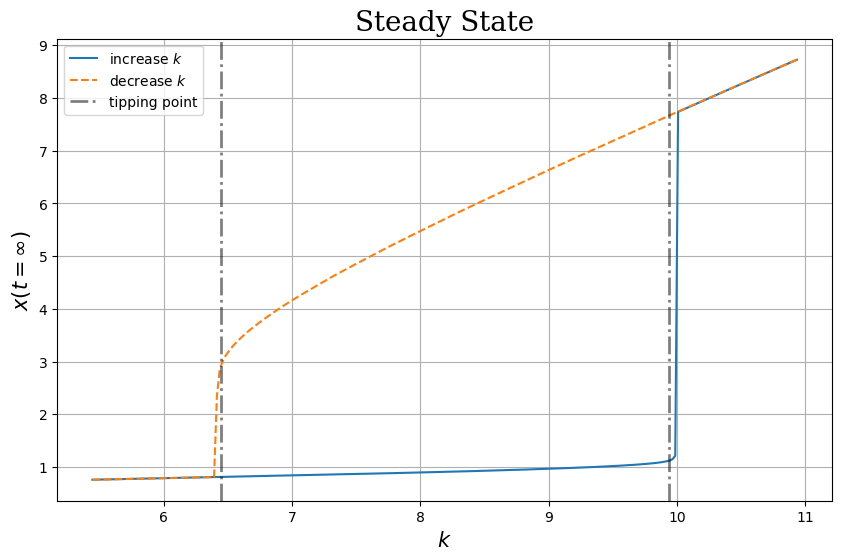

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

ax.plot(k_increase,x_increase, label=r'increase $k$')
ax.plot(k_decrease, x_decrease, linestyle='--',label=r'decrease $k$')
ax.axvline(k1, linestyle='-.', c = 'black', alpha=0.5, label='tipping point',lw=2)
ax.axvline(k2, linestyle='-.', c = 'black', alpha=0.5,lw=2)

ax.set_xlabel(r"$k$", size = 15)
ax.set_ylabel(r"$x(t=\infty)$",size=15,)

ax.set_title("Steady State", family = 'serif', size=20)

ax.grid(True)
ax.legend(loc = 'upper left')
plt.show()

In [32]:
X = np.hstack((x_increase,x_decrease,x_increase2,x_decrease2))
K = np.hstack((k_increase,k_decrease,k_increase2,k_decrease2))

# X = np.hstack((X,X))
# K = np.hstack((K,K))
train_idx = np.arange(0,len(X),10)
X_train = X[train_idx]
K_train = K[train_idx]

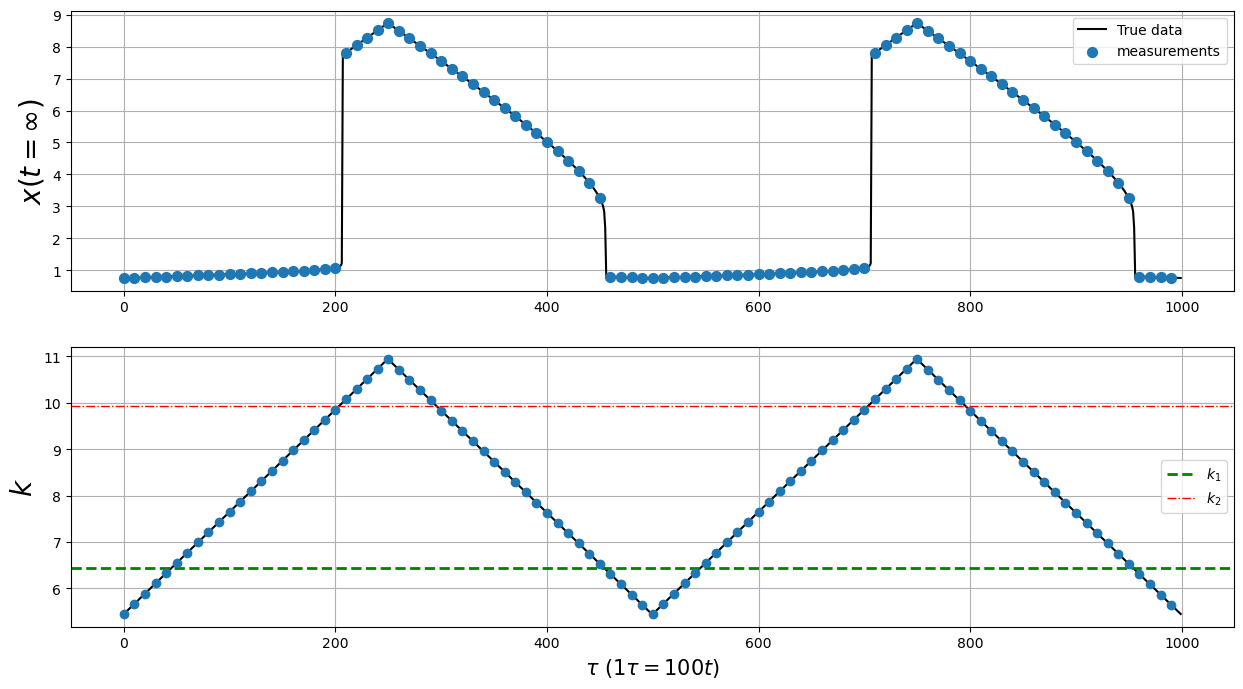

In [33]:
fig, ax = plt.subplots(2,1,figsize=(15,8))
ax[0].plot(X,c='black', label='True data')
ax[0].scatter(train_idx,X_train,marker='o',lw=1,zorder=5,s=50,label="measurements")
ax[0].set_ylabel(r"$x(t=\infty)$",size=20,)
ax[0].grid(True)
ax[0].legend()


ax[1].plot(K,c='black')
ax[1].scatter(train_idx,K_train,zorder=5)
ax[1].set_ylabel(r"$k$",size=20)
ax[1].set_xlabel(r"$\tau$ ($1 \tau = 100 t$)",size=15)
ax[1].axhline(k1, c='green', linestyle='--',lw=2,label=r'$k_1$')
ax[1].axhline(k2, c='red', linestyle='-.',lw=1,label=r'$k_2$')
ax[1].legend()
ax[1].grid(True)


plt.show()

## Format for Neuromancer

In [89]:
import torch
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

torch.manual_seed(0)

In [90]:
nx = 1 if len(X.shape) ==1 else X.shape[-1]
nsim = 800
nstep = 5
batch_size = 100


In [91]:
nbatch = n_sim // n_steps
tot_length = int(n_batch * n_steps)

trainX = X[:tot_length].reshape(nbatch,nstep,nx)
devX = trainX.copy()
testX = trainX.copy()

In [92]:
# trainX[:,0:1,:] # the first measurement in the prediction horizon?

In [93]:
trainX[0], X[:nstep], trainX.shape

(array([[0.7604912 ],
        [0.76139   ],
        [0.76251122],
        [0.76368621],
        [0.7648677 ]]),
 array([0.7604912 , 0.76139   , 0.76251122, 0.76368621, 0.7648677 ]),
 (160, 5, 1))

In [94]:
trainX = torch.tensor(trainX, dtype=torch.float32)
devX = torch.tensor(devX, dtype = torch.float32)
testX = torch.tensor(testX, dtype= torch.float32)

In [95]:
# Neuromancer format
train_data = DictDataset({"X": trainX, "xn": trainX[:,0:1,:]}, name="train")
dev_data = DictDataset({"X": devX, "xn": devX[:,0:1,:]}, name="dev")
test_data= DictDataset({"X": testX, "xn": testX[:,0:1,:]},)

In [97]:
train_loader = DataLoader(train_data, batch_size=batch_size,
                          collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size = batch_size,
                        collate_fn = dev_data.collate_fn, shuffle=True)